# XGboosting

## Imports


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [5]:
import xgboost as xgb
from util import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

NUM_FOLDS = 10


## Reading the data


In [6]:
X, y = get_train_data(path='../data/train.csv')

In [7]:
# standardize the data
X = standardize_features(X)

In [8]:
X.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training the model


### Parameters for Tree Booster

- **eta** *[default=0.3, alias: learning_rate]*:
  - Step size shrinkage used in updates to prevent overfitting. It shrinks the feature weights after each boosting step to make the process more conservative.
  - Range: [0,1]

- **gamma** *[default=0, alias: min_split_loss]*:
  - Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values make the algorithm more conservative.
  - Range: [0,∞]

- **max_depth** *[default=6]*:
  - Maximum depth of a tree. Increasing it makes the model more complex and more likely to overfit. 0 indicates no limit on depth.
  - Range: [0,∞]

- **min_child_weight** *[default=1]*:
  - Minimum sum of instance weight needed in a child node. If partitioning a leaf results in a child with a sum of instance weight less than this, further partitioning is halted.
  - Range: [0,∞]

- **max_delta_step** *[default=0]*:
  - Maximum delta step allowed for each leaf output. Values >0 make the update step more conservative.
  - Range: [0,∞]

- **subsample** *[default=1]*:
  - Subsample ratio of the training instances. Setting it to 0.5 means randomly sampling half of the training data prior to growing trees.
  - Range: (0,1]

- **sampling_method** *[default=uniform]*:
  - The method to sample training instances. 
  - Choices: uniform (equal probability for each instance), gradient_based (probability proportional to the absolute value of gradients).

- **colsample_bytree, colsample_bylevel, colsample_bynode** *[default=1]*:
  - Subsampling of columns.
  - Range: (0, 1]
  - `colsample_bytree`: Subsample ratio of columns when constructing each tree.
  - `colsample_bylevel`: Subsample ratio of columns for each level.
  - `colsample_bynode`: Subsample ratio of columns for each node (split).

- **lambda** *[default=1, alias: reg_lambda]*:
  - L2 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **alpha** *[default=0, alias: reg_alpha]*:
  - L1 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **tree_method** *[default=auto]*:
  - The tree construction algorithm used in XGBoost.
  - Choices: auto, exact, approx, hist.

- **scale_pos_weight** *[default=1]*:
  - Control the balance of positive and negative weights, useful for unbalanced classes.

In [30]:
xgb_model = xgb.XGBClassifier(device='cuda')
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = xgb_model.predict(X_train)

# Compute training error
training_error = np.mean(y_train != y_train_pred)
print("Training error:", training_error)
print("Training accuracy:", 1 - training_error)

c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training error: 0.040425
Training accuracy: 0.959575


`cross_validate` function in scikit-learn is used for evaluating estimator performance using cross-validation. It takes several parameters to customize its behavior. Here are the main parameters:

1. **estimator**: This is the machine learning estimator (model) that you want to evaluate.

2. **X**: The feature matrix (data) to fit the model on.

3. **y**: The target values (labels) corresponding to X.

4. **cv**: The cross-validation strategy. It could be an integer specifying the number of folds in a KFold, a cross-validation splitter, or an iterable yielding train/test splits.

5. **scoring**: A single string or a callable to evaluate the predictions on the test set. For example, `'accuracy'`, `'precision'`, `'recall'`, `'f1'`, etc.

6. **n_jobs**: The number of CPU cores to use for computation. `-1` means using all processors.

7. **return_train_score**: Whether to include training scores in the output. Default is `False`.

8. **return_estimator**: Whether to return the fitted estimators for each split. Default is `False`.

9. **verbose**: Controls the verbosity: the higher, the more messages.

10. **fit_params**: Parameters to pass to the `fit` method of the estimator.

11. **pre_dispatch**: Controls the number of jobs dispatched during parallel execution. `-1` means all processes are dispatched at once, `2` means that two processes are dispatched, and `None` means that as many processes as CPUs are used.

These are the main parameters, but there are a few more which you can find in the scikit-learn documentation for the `cross_validate` function.

In [15]:
cv_results = cross_validate(xgb_model, X_train, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

accuracy:  0.913625
f1_macro:  0.6589212919082267
f1_micro:  0.913625


## Model Analysis


### Feature Importance Plot

A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.


     feature  importance
34    var_34        55.0
133  var_133        54.0
6      var_6        54.0
170  var_170        54.0
166  var_166        52.0
..       ...         ...
64    var_64        11.0
98    var_98        10.0
124  var_124        10.0
126  var_126        10.0
189  var_189         9.0

[200 rows x 2 columns]


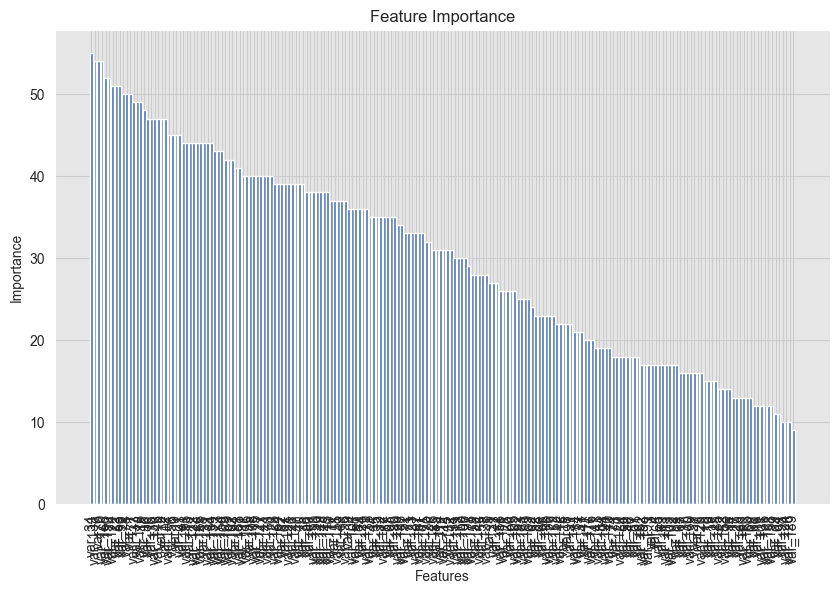

In [21]:
# Assuming you have trained your XGBoost classifier and stored it in xgb_model
importance = xgb_model.get_booster().get_score(importance_type='weight')
features = list(importance.keys())
importance_values = list(importance.values())

# Get feature importance using the provided function
feature_importance = get_feature_importance(features, importance_values)

# Print or return the sorted DataFrame
print(feature_importance)

plt = get_feature_importance_plot(
    feature_importance, modelname='XGB')
plt.show()


### Learning Curves Plot

show the training error (Ein) and validation error (Eval) as a function of the training set size


In [26]:
X_train_temp = X_train.copy()

In [27]:
imp_threshold = 15
for i in range(len(feature_importance)):
    if feature_importance['importance'][i] < imp_threshold:
        # remove the feature from the training data that has importance < imp_threshold
        X_train_temp = X_train_temp.drop(
            columns=feature_importance['feature'][i])
len(X_train_temp.columns)

178

In [28]:

cv_results = cross_validate(xgb_model, X_train_temp, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


accuracy:  0.9133687499999998
f1_macro:  0.6588911966751265
f1_micro:  0.9133687499999998
accuracy:  0.9133687499999998
f1_macro:  0.6588911966751265
f1_micro:  0.9133687499999998


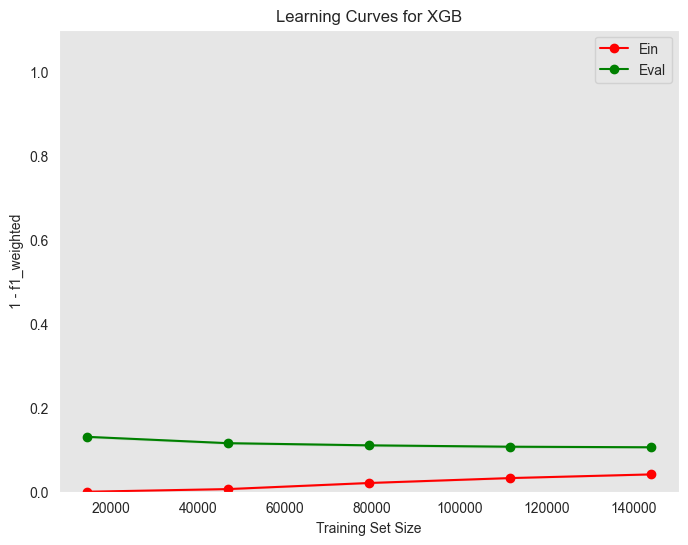

In [29]:
plt = get_learning_curve_plot(estimator=xgb.XGBClassifier(), X=X_train, y=y_train, cv=NUM_FOLDS, modelname='XGB')
plt.show()


### Partial Dependence Plot

A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.

From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.


In [ ]:
plt = get_partial_dependencies_plot(lr, X_train_temp, modelname='Logistic Regression', save=True)
# plt.show()


### Hyperparameter Tuning

This is a process of adjusting the parameters of a model to optimize its performance. It can be done using techniques like grid search, random search, or Bayesian optimization.


In [19]:
# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}


### Grid Search


In [20]:
grid_search = get_grid_search(estimator=LogisticRegression(
    max_iter=10000), param_grid=param_grid, X=X_train, y=y_train, cv=NUM_FOLDS, scoring='f1_weighted')
# Print the results
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print("Test score with best parameters:", grid_search.score(X_test, y_test))


Best parameters found: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best score found: 0.8973298346690788
Test score with best parameters: 0.8953594884607815


### Heatmap


<module 'matplotlib.pyplot' from 'c:\\Users\\peter\\miniconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

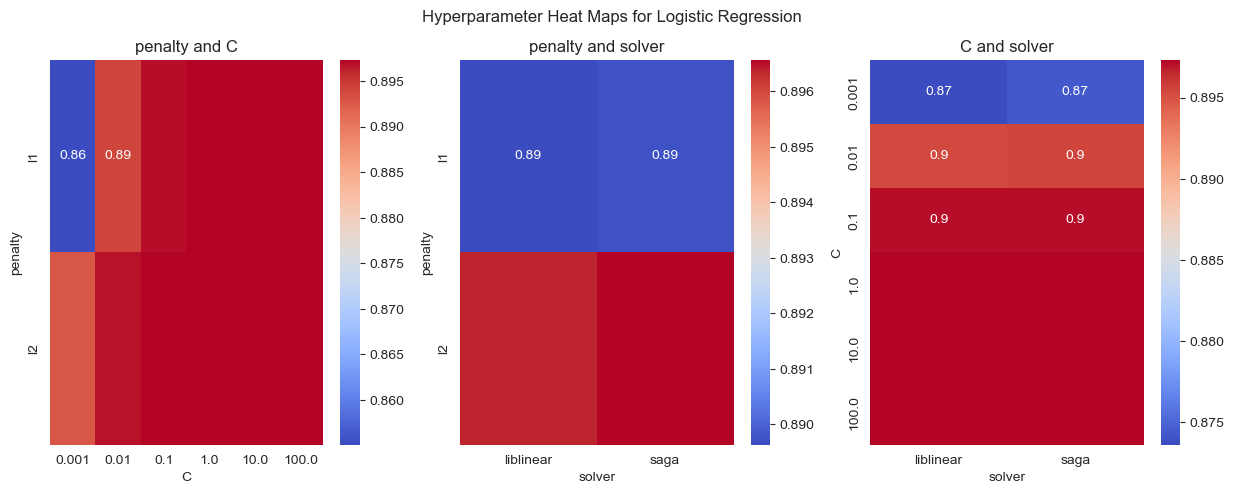

In [26]:
plot_hyper_param_heat_maps(param_grid, grid_search,modelname='Logistic Regression')


### Train-Validation Curve


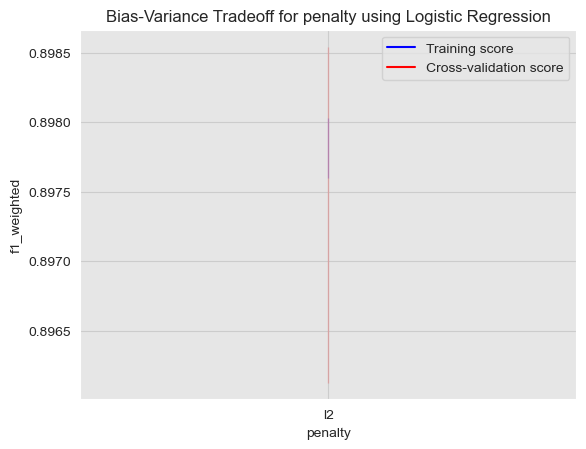

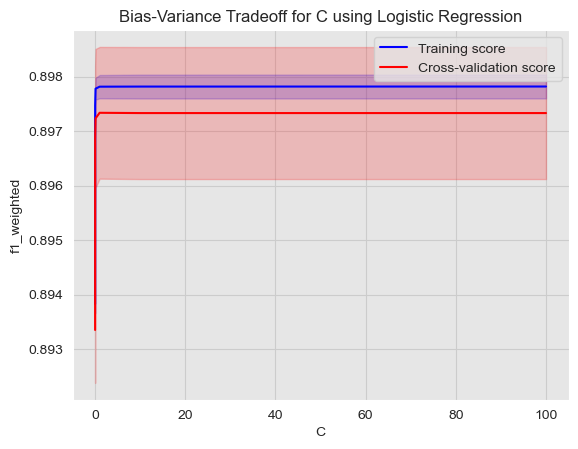

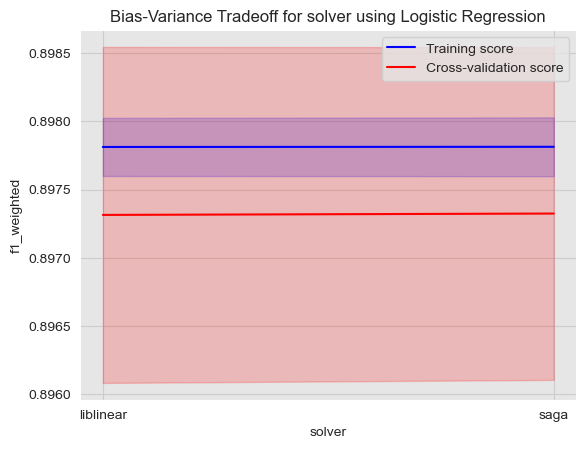

In [27]:
plot_hyper_param_train_validation_curve(estimator=LogisticRegression(
    max_iter=10000), param_grid=param_grid, X=X_train, y=y_train, cv=NUM_FOLDS, scoring='f1_weighted', modelname='Logistic Regression')


## Bias-Variance Analysis


In [28]:

lr = LogisticRegression(C=0.1, max_iter=10000, solver='saga')

mse, bias, var = get_bias_variance(
    lr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


In [29]:
print("mse: ", mse)
print("bias: ", bias)
print("var: ", var)


mse:  0.08687175
bias:  0.08357837
var:  0.003293380000000001


### Decision Boundary Plot

This is plot shows the decision boundary of the model. It can help visualize how the model separates the classes in the dataset


c:\Users\peter\miniconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but LogisticRegression is expecting 200 features as input.

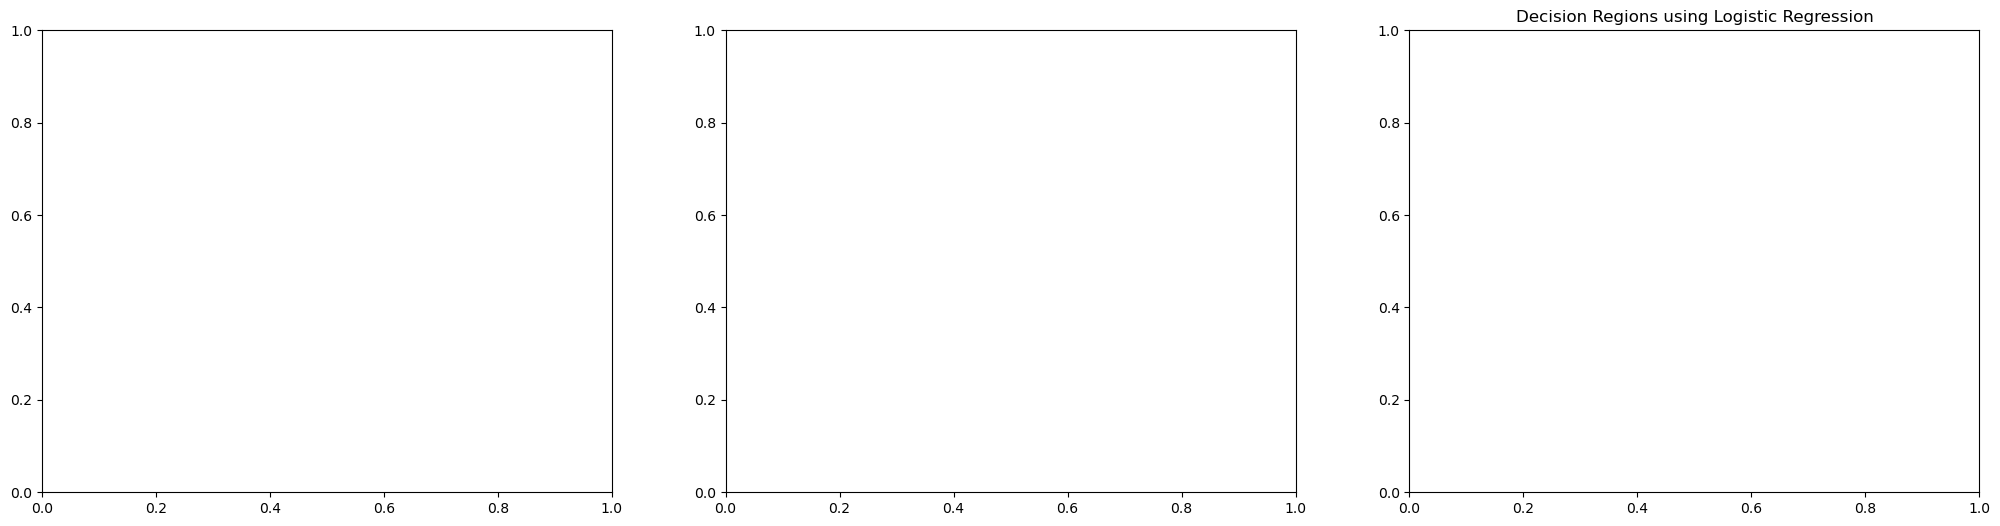

In [34]:
# reset style to default
plt.style.use('default')
# TODO: Fix this error

plt = get_decision_regions(LogisticRegression(max_iter=10000, solver='saga'),
                              X_train, X_train[X_train.columns[0]], X_train[X_train.columns[1]], y_train, C=[0.001, 0.1, 10], modelname='Logistic Regression')
plt.show()
